In a recent cookbook, the [Healthspan Solution](https://healthspansolution.com/), the authors propose a new way to categorize food: the food triangle.

First of all, only whole food ingredients are considered. Then, rather than grouping foods into one of the macronutrients (fat, protein and carbohydrates), they are sorted by energy density on the one hand (top / down), and by source (animal on the left, plants on the right) on the other:

![Food Triangle](https://rschwarz.github.io/files/food_triangle.jpeg)

The recommendation is to eat on the "right side", in particular near the top, in order to get sufficient micronutrients while keeping energy intake in check.

On the other hand, many traditional recipes choose foods from both sides near the bottom, yielding the highest energy density while promoting fat storage due to oxidative priority.

I like this scheme, but I wondered whether most foods could really be assigned one of these sides easily.
So this post is about visualizing foods by their energy density and relative source of energy (fat vs carbohydrates).

In [1]:
# Activate custom environment ad load packages
using Pkg
Pkg.activate("../../environments/food-triangle/");

using CSV
using DataFrames
using VegaLite

 Activating environment at `~/src/rschwarz.github.io/environments/food-triangle/Project.toml`


In [2]:
# Load nutrition data
foods = DataFrame(CSV.File("../files/foods.csv"))
@show size(foods)
first(foods, 3)

size(foods) = (142, 7)


,Source,Category,Food,Energy,Protein,Fat,Carbohydrates
,String,String,String,Float64,Float64,Float64,Float64
1,Plant,Grain,Oats,272.0,2.4,1.6,10.1
2,Plant,Grain,Barley,388.0,2.9,0.9,18.0
3,Plant,Grain,Buckwheat,304.0,2.5,0.6,14.1


## Energy

Our nutrition data lists 142 different foods from different categories with energy (in kJ per 100g) as well as relative weight of the macronutrients.

Since fat has a much higher energy density, we will replace the weight values by the energy contribution per macronutrient.

In [3]:
foods.Fat = 37.0 .* foods.Fat
foods.Carbohydrates = 16.0 .* foods.Carbohydrates
foods.Protein = 17.0 .* foods.Protein
first(foods, 3)

,Source,Category,Food,Energy,Protein,Fat,Carbohydrates
,String,String,String,Float64,Float64,Float64,Float64
1,Plant,Grain,Oats,272.0,40.8,59.2,161.6
2,Plant,Grain,Barley,388.0,49.3,33.3,288.0
3,Plant,Grain,Buckwheat,304.0,42.5,22.2,225.6


## Food Triangle

Our quantified food triangle will be implemented as a scatter plot. For the vertical axis, we use the total energy density (low energy on the top). For the horizontal axis, we take the difference of energy contribution from carbohydrates and fat. So, foods rich in fat tend to be near the left, while foods rich in carbohydrates are on the right. Foods in the middle could have either both fat and carbohydrates, or neither, being rich in protein instead. 

In [4]:
foods.fat_cho = foods.Carbohydrates - foods.Fat
first(foods, 3)

,Source,Category,Food,Energy,Protein,Fat,Carbohydrates,fat_cho
,String,String,String,Float64,Float64,Float64,Float64,Float64
1,Plant,Grain,Oats,272.0,40.8,59.2,161.6,102.4
2,Plant,Grain,Barley,388.0,49.3,33.3,288.0,254.7
3,Plant,Grain,Buckwheat,304.0,42.5,22.2,225.6,203.4


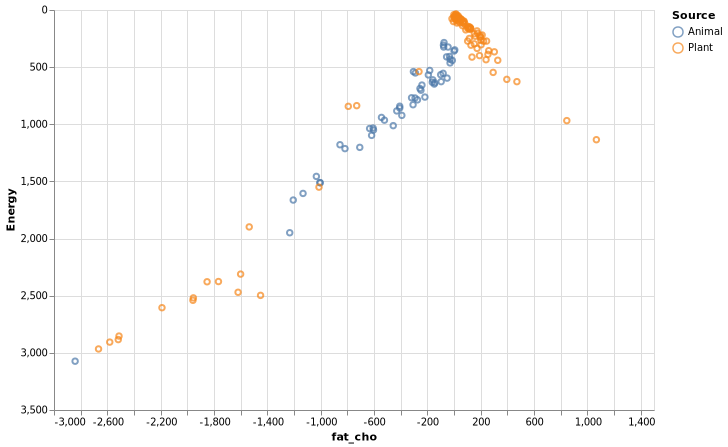

In [5]:
foods |> @vlplot(height=400, width=600, :point,
                 x=:fat_cho, y={:Energy, sort="descending"}, color=:Source)

To my surprise, most foods do actually line up on either side of the triangle and few are found in the center.

We can also see that all animal foods are on the left, while most plant foods are on the right.

Finally, it's quite obvious that the left side goes a lot "deeper" than the right. Foods rich in fat have a much higher potential for high energy density!

## Plant-based Food

Let's go into more detail, looking only at plant foods now, split into more categories.

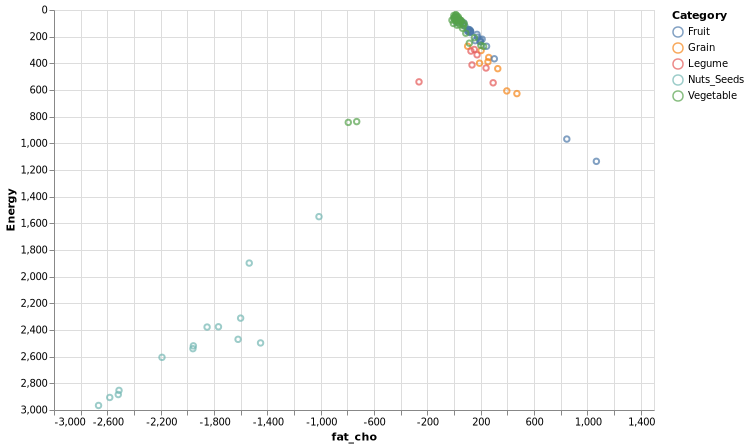

In [6]:
filter(row -> row.Source == "Plant", foods) |>
    @vlplot(height=400, width=600, :point,
            x=:fat_cho, y={:Energy, sort="descending"}, color=:Category)

We can see that the different categories form nice clusters in the this view.

Most items on the left side seem to be either nuts or seeds. Let's zoom in on these.

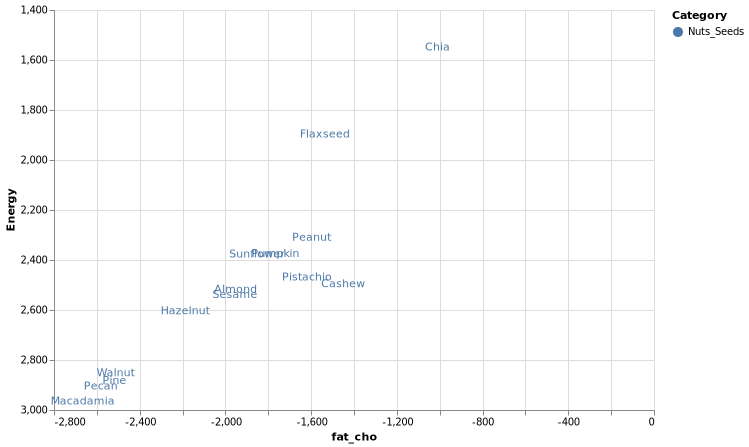

In [7]:
filter(row -> row.Category == ("Nuts_Seeds"), foods) |>
    @vlplot(height=400, width=600, :text, text=:Food,
            x=:fat_cho, y={:Energy, sort="descending", scale={zero=false}}, color=:Category)

When we remove nuts and seeds, we can get a better picture of the foods near the top of the triangle.

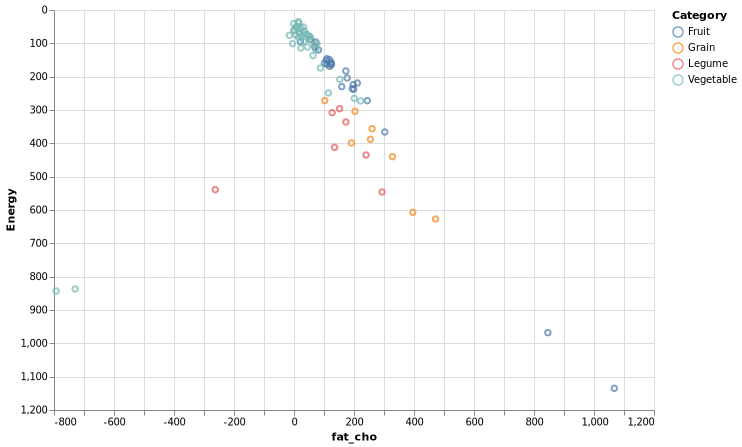

In [8]:
filter(row -> row.Source == "Plant" && row.Category != "Nuts_Seeds", foods) |>
 @vlplot(height=400, width=600, :point,
         x=:fat_cho, y={:Energy, sort="descending"}, color=:Category)

There are still some outliers of higher energy density:

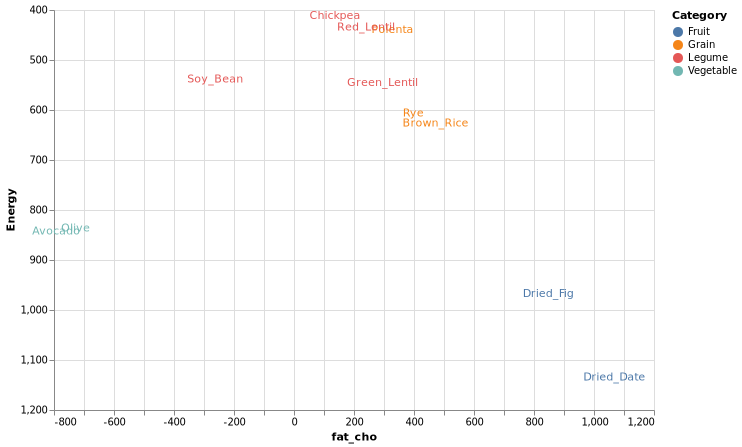

In [9]:
filter(row -> row.Source == "Plant" && row.Category != "Nuts_Seeds"
              && row.Energy > 400.0, foods) |>
 @vlplot(height=400, width=600, :text, text=:Food,
         x=:fat_cho, y={:Energy, sort="descending",scale={zero=false}}, color=:Category)

OK, so there are two vegetables high in fat (avocado and olive) and also two types of dried fruits, which might not be considered proper whole foods, I guess.

The other items are either grains or legumes, but not fruits or vegetables.

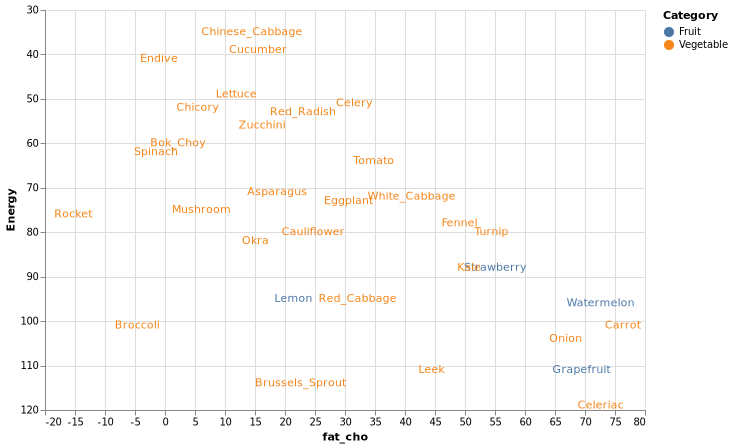

In [10]:
filter(row -> row.Source == "Plant" && row.Category != "Nuts_Seeds"
              && row.Energy < 120.0, foods) |>
 @vlplot(height=400, width=600, :text, text=:Food,
         x=:fat_cho, y={:Energy, sort="descending",scale={zero=false}}, color=:Category)

Near the top we have mostly vegetables and some fruits. The foods lowest in energy density are either cabbages, leafy greens or watery vegetables.

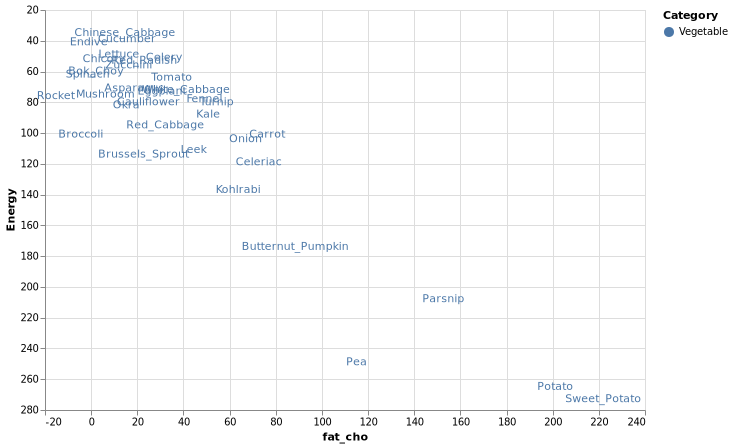

In [11]:
filter(row -> row.Category == "Vegetable" &&  row.Fat < 200, foods) |>
    @vlplot(height=400, width=600, :text, text=:Food,
            x=:fat_cho, y={:Energy, sort="descending", scale={zero=false}}, color=:Category)

Looking at all vegetables now, we can see that the starchy vegetables are near the bottom.
Should peas actually be with the legumes?

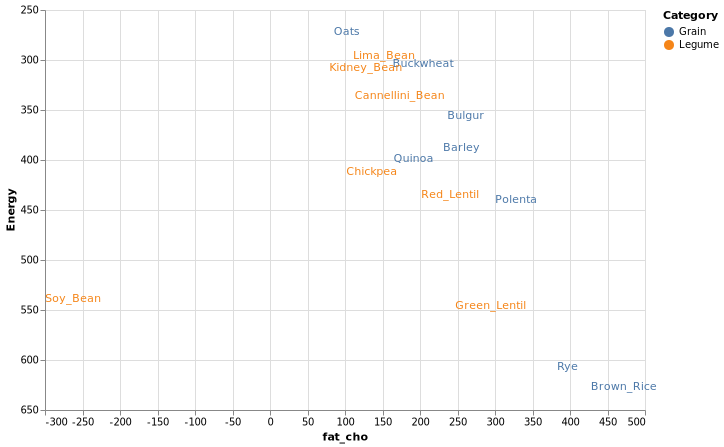

In [12]:
filter(row -> row.Category in ("Grain", "Legume"), foods) |>
    @vlplot(height=400, width=600, :text, text=:Food,
            x=:fat_cho, y={:Energy, sort="descending", scale={zero=false}}, color=:Category)

All grains and legumes are higher in density than vegetables. It should be noted here that the numbers apply to cooked, not fresh or dried foods. So maybe oats are only at the top here, because they are typically cooked with more water compared to other grains?

Soy beans are quite the outlier here, storing most of their energy as fat.

## Animal-based Foods

Let's now turn to animal foods, all located on the left side.

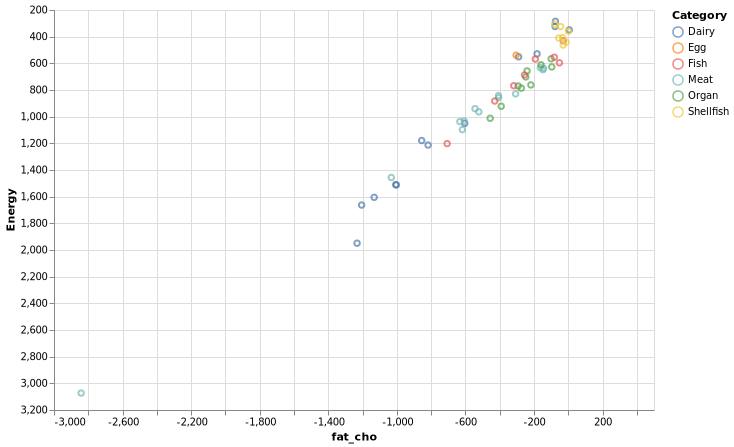

In [13]:
filter(row -> row.Source == "Animal", foods) |>
 @vlplot(height=400, width=600, :point,
         x=:fat_cho, y={:Energy, sort="descending",scale={zero=false}}, color=:Category)

There is one outlier with very high energy content:

In [14]:
first(sort(foods, :Energy, rev=true), 3)

,Source,Category,Food,Energy,Protein,Fat,Carbohydrates,fat_cho
,String,String,String,Float64,Float64,Float64,Float64,Float64
1,Animal,Meat,Pork_Belly,3073.0,229.5,2841.6,0.0,-2841.6
2,Plant,Nuts_Seeds,Macadamia,2966.0,156.4,2738.0,72.0,-2666.0
3,Plant,Nuts_Seeds,Pecan,2906.0,166.6,2660.3,78.4,-2581.9


It's pork belly, with lots of fat. But actually not much more than some nuts.

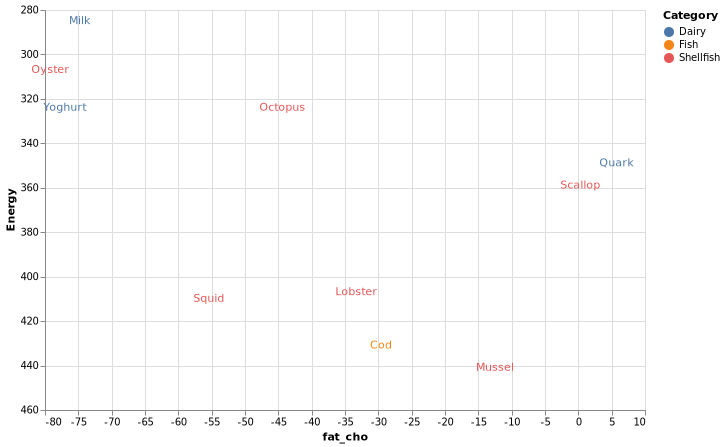

In [15]:
filter(row -> row.Source == "Animal" && row.Energy < 450.0, foods) |>
 @vlplot(height=400, width=600, :text, text=:Food,
         x=:fat_cho, y={:Energy, sort="descending",scale={zero=false}}, color=:Category)

Near the top, with lower energy density (and high water content), we can find dairy products and shellfish.

Dairy also has significant carbohydrates, but the scallops and mussels seem to store almost all of their energy as protein.

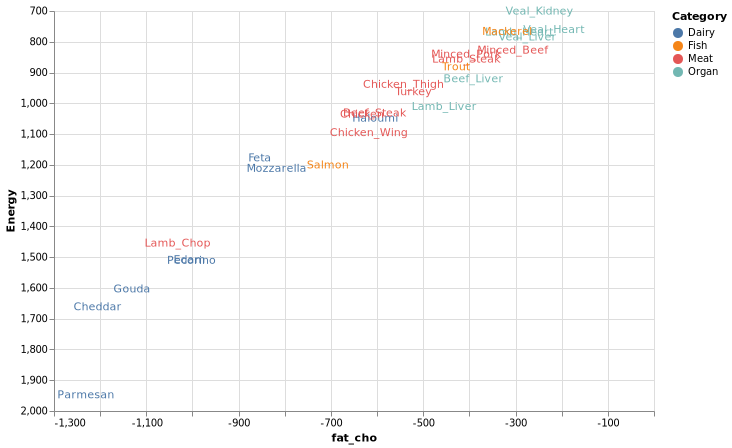

In [16]:
filter(row -> row.Source == "Animal" && 700.0 < row.Energy < 2000.0, foods) |>
 @vlplot(height=400, width=600, :text, text=:Food,
         x=:fat_cho, y={:Energy, sort="descending",scale={zero=false}}, color=:Category)

Leaving out the pork belly, the highest energy foods are cheeses. The fishes, meats and organ are rich in fat as well as protein.

Still, I would have expected liver to be farther down. Also, I'm surprised by the wide spread of fat content among different types of fish:

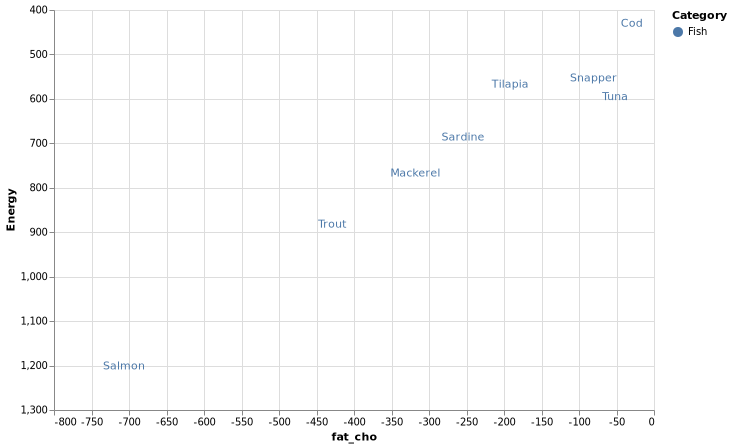

In [17]:
filter(row -> row.Category == "Fish", foods) |>
 @vlplot(height=400, width=600, :text, text=:Food,
         x=:fat_cho, y={:Energy, sort="descending",scale={zero=false}}, color=:Category)

Overall, I was positively surprised by the accuracy of the food triangle schema when looking at the actual numbers.

## Energy (Kernel) Density

As a final analysis, let's compare the energy density of plants and animals (by count) in a simpler, one-dimensional chart:

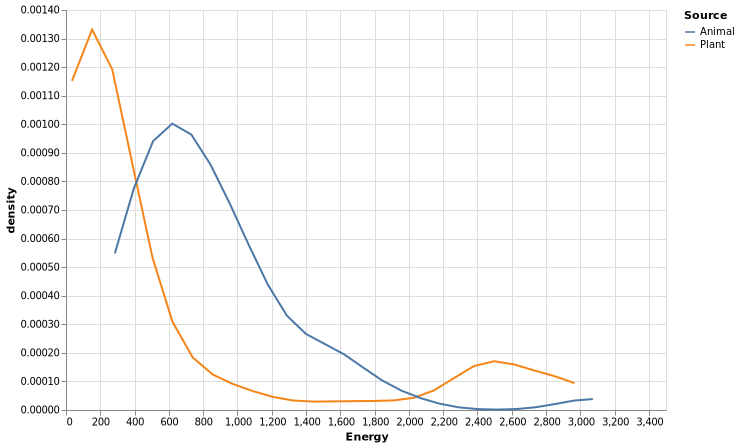

In [18]:
foods |> @vlplot(height=400, width=600, :line,
    transform=[{density="Energy", bandwidth=200, groupby=["Source"]}],
    x={"value:q", title="Energy"}, y="density:q", color=:Source)